# State Polygons

## Triangular Meshes

This notebook considers states as polygons for the purposes of generating triangular meshes. The mesh generator will use the Delaunay triangulation and some Julia code to generate the triangular mesh of the state. In order to use the Julia code, we use the IPython magic from the `julia` library.

In [1]:
%load_ext julia.magic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact
import ipywidgets as widgets
import pickle
from utils import *

Initializing Julia runtime. This may take some time...


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/julia/magic.py:152: UserWarning: Incompatible upstream libraries. Got ImportError: No module named 'prompt_toolkit.lexers'
  warnings.warn(template.format(err))


We begin by unpickling the dictionary that was created in the last notebook.

In [2]:
with open("../data/polygons-pickle.txt", "r+b") as f:
    polygons = pickle.load(f)

### Plotting Polygons

Before creating the mesh generator, we first need to plot polygons. To that end, we define a function `plot_polygon` below which plots a _closed_ polygon from a list of points.

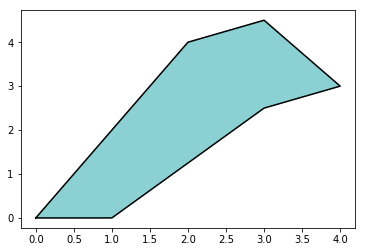

In [31]:
def plot_polygon(pv):
    """
    Plots a closed polygon from a list of points (list of lists)
    
    Arguments:
        pv - list of points (list of lists)
    """
    assert pv[0] == pv[-1], "Polygon must be closed"
    x, y = [vertex[0] for vertex in pv], [vertex[1] for vertex in pv]
    plt.plot(x, y, color = "black")
    plt.fill(x, y, color = "#8bd0d3")
    plt.axis(option = "equal");
    
# sample polygon
poly = [[0,0], [1,2], [2,4], [3,4.5], [4,3], [3,2.5], [1,0], [0,0]]
plot_polygon(poly)

### Mesh Generator

The code that runs the algorithm to generate the triangular mesh is written in Julia. In order to use it, we make use of some IPython magic that will allow us to run Julia code in this Python notebook. We start by importing the file that contains the code we need for the mesh generator, [`mesh-generator.jl`](mesh-generator.jl).

In [4]:
%julia include("mesh-generator.jl")

<PyCall.jlwrap pmesh>

The function `pmesh` defined in that file generates a triangular mesh of a polygon by returning an array of nodes `p` and an array of triangles `t`. `p` contains coordinates that describe points in the plane. `t` contains arrays of indices which map to elements in `p` and define triangles.

For example, if we had `p` and `t` defined as follows:

```python
p = [[0,0], [1,1], [1,2], [3,2], [3,1], [2,0], [0,0]]
t = [[2, 1, 4], ...]
```

then one of the triangles in the mesh would have vertices $(1,2)$, $(1,1)$, and $(3,1)$.

In [5]:
%%julia
poly = [[$poly[p,1], $poly[p,2]] for p in 1:size($poly, 1)]
p,t = pmesh(poly, 0.2);

([array([0, 0], dtype=int64),
  array([0.08333333, 0.16666667]),
  array([0.16666667, 0.33333333]),
  array([0.25, 0.5 ]),
  array([0.33333333, 0.66666667]),
  array([0.41666667, 0.83333333]),
  array([0.5, 1. ]),
  array([0.58333333, 1.16666667]),
  array([0.66666667, 1.33333333]),
  array([0.75, 1.5 ]),
  array([0.83333333, 1.66666667]),
  array([0.91666667, 1.83333333]),
  array([1, 2], dtype=int64),
  array([1.08333333, 2.16666667]),
  array([1.16666667, 2.33333333]),
  array([1.25, 2.5 ]),
  array([1.33333333, 2.66666667]),
  array([1.41666667, 2.83333333]),
  array([1.5, 3. ]),
  array([1.58333333, 3.16666667]),
  array([1.66666667, 3.33333333]),
  array([1.75, 3.5 ]),
  array([1.83333333, 3.66666667]),
  array([1.91666667, 3.83333333]),
  array([2, 4], dtype=int64),
  array([2.16666667, 4.08333333]),
  array([2.33333333, 4.16666667]),
  array([2.5 , 4.25]),
  array([2.66666667, 4.33333333]),
  array([2.83333333, 4.41666667]),
  array([3. , 4.5]),
  array([3.1 , 4.35]),
  array([

In the cell below, we transfer the `p` and `t` arrays to Python to be used for plotting.

In [6]:
p, t = %julia p, t

To plot the triangular mesh, we need to plot both the polygon and the triangles overlaid. To this end, we first call the `plot_polygon` function on the polygon and then iterate through each triangle to plot a _closed_ triangle using the indices in `t` and the nodes in `p`.

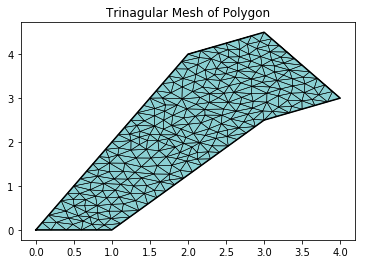

In [35]:
def plot_triangulation(pv, p, t):
    """
    Plots polygon and triangular mesh
    
    Arguments:
        pv - list of points that describe closed polygon
        p  - list of nodes for the triangular mesh
        t  - list of lists of indices of p that form triangles, 1-indexed
    """
    plot_polygon(pv)
    for tri in t:
        x, y = [p[i-1][0] for i in list(tri) + [tri[0]]], [p[i-1][1] for i in list(tri) + [tri[0]]]
        plt.plot(x, y, color = "black", linewidth=0.5)
        
plot_triangulation(poly, p, t)
plt.title("Trinagular Mesh of Polygon");

For ease of use, we put this entire pipeline into a function `generate_and_plot_mesh` which can optionally return the arrays `p` and `t`.

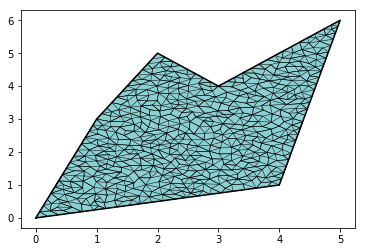

In [9]:
def generate_and_plot_mesh(pv, hmax=0.2, return_p_t = False):
    """
    Generates and plots triangular mesh of a closed polygon
    
    Arguments:
        pv         - list of points that describe a closed polygon
        hmax       - parameter to describe density of triangles
        return_p_t - bool; whether or not to return list of nodes `p` 
                     and list of indices of nodes `t`
    """
    %julia p,t = pmesh($pv, $hmax)
    p, t = %julia p, t
    plot_triangulation(pv, p, t)
    
    if return_p_t:
        return p, t
    
generate_and_plot_mesh([[0,0], [1,3], [2,5], [3,4], [5,6], [4,1], [0,0]])

### State Meshes

To generate the triangular meshes of states, we first need to reorder the coordinates. Because latitude and longitude pairs are recorded as $(\text{lat},\text{lon})$ but longitude is on the $x$-axis, we need to reorder all of these pairs in the `polygons` dictionary. The function `state_to_poly` below takes a state name as its argument and returns a list of $(\text{lon},\text{lat})$ pairs to be used as a polygon.

In [36]:
def state_to_poly(state):
    """
    Converts (lat, lon) pairs for a state to (lon, lat) for use
    as a polygon
    
    Arguments:
        state - state name to be converted
    """
    points = polygons[state]
    x, y = [point[1] for point in points], [point[0] for point in points]
    return [[xi, yi] for xi, yi in zip(x, y)]

As a sanity check, we use the two cells below to verify that the plots end up the same (with some style differences, of course).

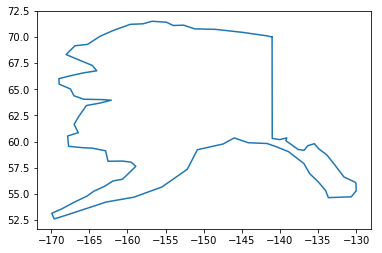

In [37]:
plot_state("Alaska")

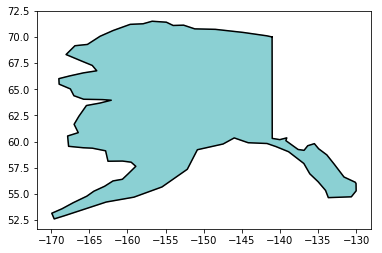

In [38]:
plot_polygon(state_to_poly("Alaska"))

Now, to generate the triangular mesh, we simply pass the array of points to the `generate_and_plot_mesh` function. We set the value of `hmax` to be 2 because if left at its default this algorithm would attempt to generate too many triangles.

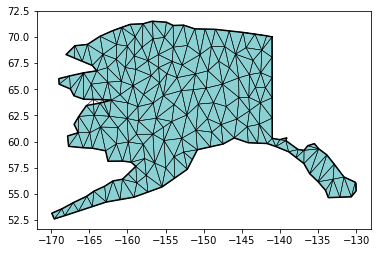

In [39]:
generate_and_plot_mesh(state_to_poly("Alaska"), 2)

### Optimizing `hmax`

The `hmax` parameter determines the number of nodes that are generated in the mesh by limiting how small the areas of the triangles can be. If the value is too small, then the algorithm takes too long and the mesh has too many triangles. If it is too large, there aren't enough triangles. To determine the best value of `hmax`, we find the change in longitude $|\max\{\text{longitudes}\} - \min\{\text{longitudes}\}|$ and then divide it by a factor (defaulted to 20).

In [26]:
def find_hmax(state, factor=20):
    """
    Hyperparameter search function to determine the value of hmax for
    a state based on its width (the maximum change in longitude)
    
    Arguments:
        state  - state to be considered
        factor - factor to divide change in longitude by; lower means
                 fewer nodes
    """
    lons = [pt[1] for pt in polygons[state]]
    max_lon, min_lon = max(lons), min(lons)
    return abs(max_lon - min_lon) / factor

### Widget-izing the Mesh Generator

Finally, we put this entire pipeline from choosing `hmax` to plotting the mesh into a function, `plot_state_mesh`, and create an IPython widget that lets you choose a state and set the value of the factor that goes into calculating `hmax`.

In [40]:
def plot_state_mesh(state, factor):
    """
    Generates triangular mesh of state and plots the mesh
    
    Arguments:
        state  - state to be considered
        factor - factor to be used when calculating hmax
    """
    hmax = find_hmax(state, factor)
    poly = state_to_poly(state)
    generate_and_plot_mesh(poly, hmax)
    plt.title("Trinagular Mesh of {}".format(state))

interact(
    plot_state_mesh,
    state = widgets.Dropdown(
        options = sorted(list(polygons.keys()))
    ),
    factor = widgets.FloatText(
        value = 20,
        description = 'hmax factor',
        disabled = False
    )
);

interactive(children=(Dropdown(description='state', options=('Alabama', 'Alaska', 'Arizona', 'Arkansas', 'Caliâ€¦